In [2]:
import pandas as pd
import os
import ast
import re

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
ai_decision = pd.read_csv("results/ai_decision.csv")
print("# of selected articles = ", ai_decision.decision.sum())

# of selected articles =  21


In [6]:
human_decision = pd.read_csv("results/human_decision.csv")
print("# of selected articles = ", human_decision.human_decision.sum())

# of selected articles =  16


In [7]:
human_decision = human_decision.sort_values(by="key").reset_index(drop=True)
ai_decision = ai_decision.sort_values(by="key").reset_index(drop=True).rename(columns={"decision": "ai_decision", "reason":"ai_reason"})

merged_decision = human_decision.copy()

for key in ["ai_decision", "ai_method_list", "ai_reason"]:
    merged_decision[key] = ai_decision[key]

merged_decision = merged_decision.map(lambda x:'[]' if pd.isna(x) else x)

In [8]:
len(merged_decision[(merged_decision.human_decision==1)&(merged_decision.ai_decision==1)])

14

### WordCloud where AI reviewer's decision matched v/s mismatched with human 

In [9]:
from collections import Counter

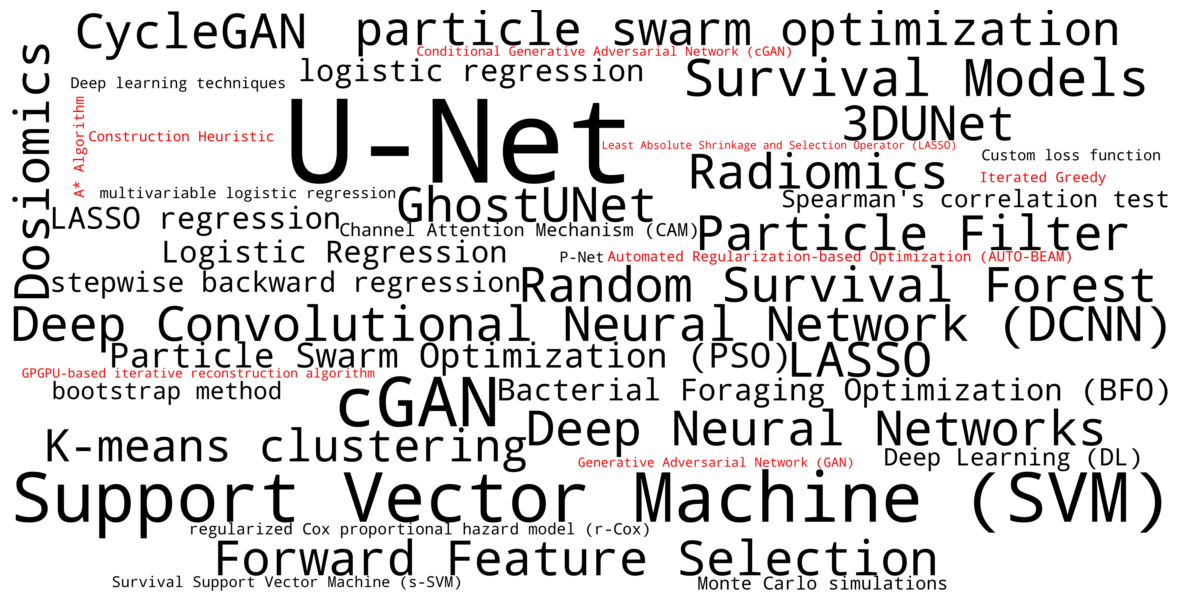

In [10]:
df = merged_decision[(merged_decision.ai_decision==merged_decision.human_decision)]
list_of_lists = [ast.literal_eval(item) for item in df.ai_method_list.to_list()]
words_agreed = sum(list_of_lists,[])

df = merged_decision[(merged_decision.ai_decision!=merged_decision.human_decision)]
list_of_lists = [ast.literal_eval(item) for item in df.ai_method_list.to_list()]
words_disagreed = sum(list_of_lists,[])
words_disagreed.remove('Not explicitly listed in the abstract.')

freq_dict = Counter(words_agreed) + Counter(words_disagreed)

# Custom color function
def color_func(word, *args, **kwargs):
    if word in words_agreed:
        return "black"
    elif word in words_disagreed:
        return "red"
    else:
        return "gray"   # fallback

# Generate one word cloud
wordcloud = WordCloud(
    width=8000, height=4000, background_color='white', random_state=42,
    color_func=color_func
).generate_from_frequencies(freq_dict)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('figures/ai_methods_screening.png', dpi=900, bbox_inches='tight')
plt.show()


## AI Methods Yearly Trend of Selected Articles

/tmp/ipykernel_445503/2611106005.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


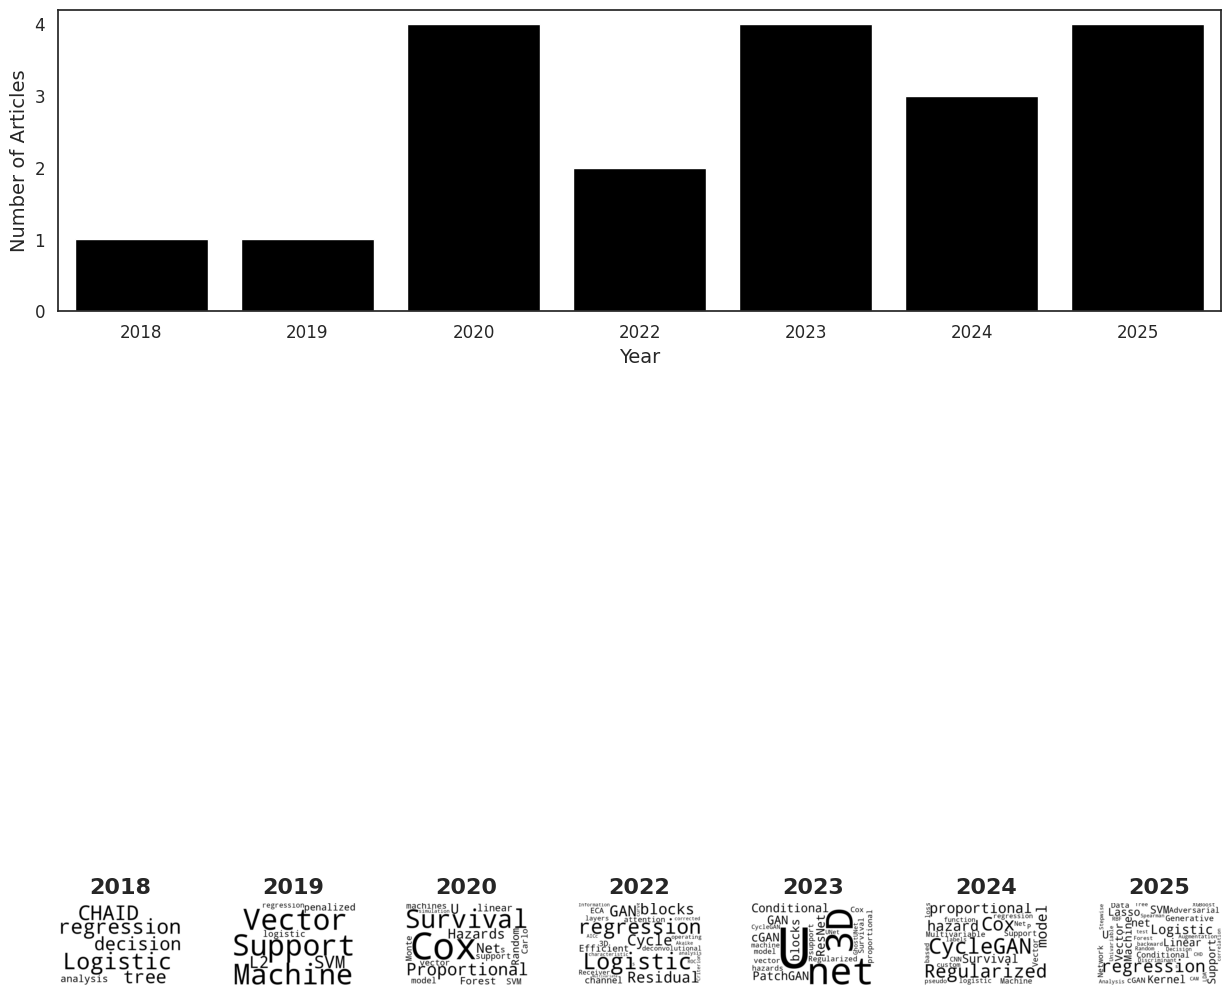

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
import seaborn as sns
import re
import math

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review.csv'
# Add more stop words to this set to exclude them from the word cloud
STOP_WORDS = set(['the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from', 'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using', 'based', 'model', 'data', 'method'])

def generate_vertical_wordcloud_plot(file_path):
    """
    Reads a CSV and generates a top-and-bottom plot with publication trends
    and yearly AI methodology word clouds.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        print("Please ensure the CSV file is in the same directory or provide the full path.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce').dropna()
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)
    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plotting Setup ---
    sns.set(style="white", font_scale=1.1)
    fig = plt.figure(figsize=(15, 18))
    # Create a GridSpec layout: 2 main rows. Top is for the bar chart, bottom for word clouds.
    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 3], hspace=0.3)

    # --- Top Panel: Number of Articles per Year ---
    ax_top = fig.add_subplot(gs_main[0])
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax_top, color='black')
    # ax_top.set_title('Number of Articles Published Per Year', fontsize=18, weight='bold', pad=20)
    ax_top.set_xlabel('Year', fontsize=14)
    ax_top.set_ylabel('Number of Articles', fontsize=14)
    ax_top.tick_params(axis='x', rotation=0)

    # --- Bottom Panel: Yearly Word Clouds ---
    # Create a nested GridSpec for the word clouds
    cols = len(years) # Number of columns for word clouds
    rows = 1
    gs_bottom = gridspec.GridSpecFromSubplotSpec(
    rows, cols, subplot_spec=gs_main[1], wspace=0.4
    )

    for i, year in enumerate(years):
        ax = fig.add_subplot(gs_bottom[i])
        year_df = df[df['Year of pubblication'] == year]
        words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(),[])
        freq_dict = Counter(words)

        if freq_dict:
            # wordcloud = WordCloud(
            #     width=600,
            #     height=400,
            #     background_color="white",
            #     color_func=lambda *args, **kwargs: "black", random_state=0
            # ).generate_from_frequencies(freq_dict)

            wordcloud = WordCloud(
                width=600,
                height=400,
                background_color="white",
                color_func=lambda *args, **kwargs: "black", random_state=0
            ).generate(" ".join(words))
            # wordcloud = WordCloud(
            #     width=400, height=200, background_color='white',
            #     stopwords=STOP_WORDS, colormap='cividis', max_words=40
            # ).generate(text)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(str(year), fontsize=16, weight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.set_title(str(year), fontsize=16, weight='bold')

        ax.axis('off')

    # Hide any unused subplots in the bottom grid
    for i in range(len(years), rows * cols):
        fig.add_subplot(gs_bottom[i]).axis('off')

    # fig.suptitle('AI Methodology Trends in Publications', fontsize=24, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('results/trend.png', dpi=900)
    plt.show()

if __name__ == '__main__':
    generate_vertical_wordcloud_plot(CSV_FILE_PATH)

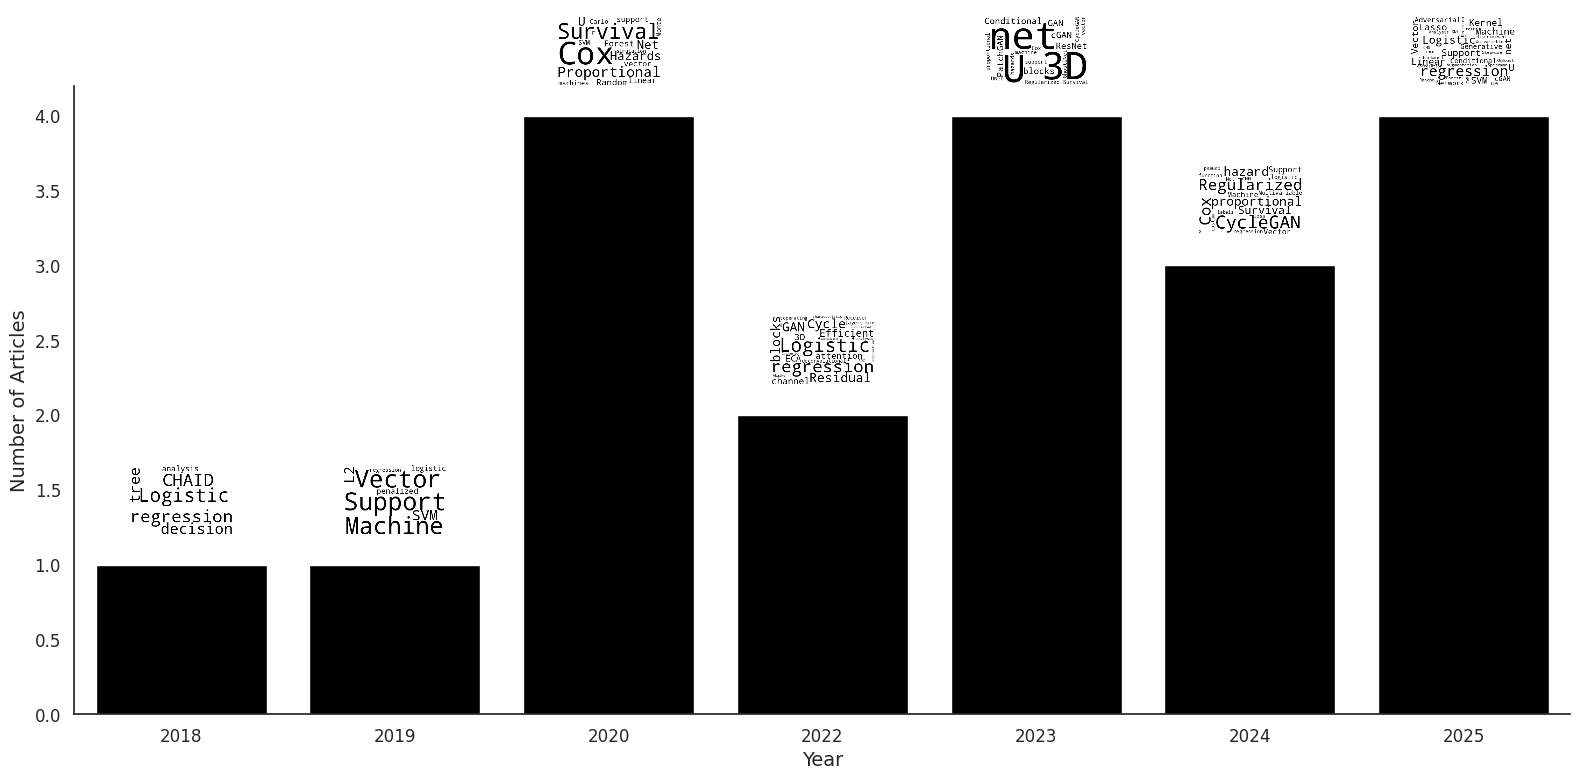

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

# --- User Configuration ---
CSV_FILE_PATH = 'results/ai_review.csv'
STOP_WORDS = set([
    'the', 'and', 'to', 'of', 'a', 'in', 'for', 'with', 'is', 'on', 'an', 'by', 'as', 's', 'are', 'from',
    'we', 'that', 'it', 'were', 'was', 'have', 'been', 'this', 'at', 'can', 'be', 'used', 'using',
    'based', 'model', 'data', 'method'
])

def generate_wordcloud_barplot(file_path):
    """
    Plots the number of articles per year with a small word cloud above each bar.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Data Preparation ---
    df['Year of pubblication'] = pd.to_numeric(df['Year of pubblication'], errors='coerce')
    df = df.dropna(subset=['Year of pubblication'])
    df['Year of pubblication'] = df['Year of pubblication'].astype(int)

    yearly_counts = df['Year of pubblication'].value_counts().sort_index()
    years = sorted(df['Year of pubblication'].unique())

    # --- Plot Setup ---
    sns.set(style="white", font_scale=1.1)
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax, color='black')
    ax.grid(False)

    # ax.set_title('AI Methodology Trends in Publications', fontsize=20, weight='bold', pad=20)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of Articles', fontsize=14)

    # --- Generate and Place Word Clouds Above Bars ---
    for i, year in enumerate(years):
        year_df = df[df['Year of pubblication'] == year]

        try:
            words = sum(year_df.ai_method_list.dropna().apply(eval).to_list(), [])
        except Exception:
            words = []

        if not words:
            continue

        freq_dict = Counter(words)
        wordcloud = WordCloud(
            width=300,
            height=200,
            background_color="white",
            color_func=lambda *args, **kwargs: "black",
            stopwords=STOP_WORDS,
            random_state=0
        ).generate(" ".join(words))

        # Convert word cloud to image array
        img = wordcloud.to_array()
        imagebox = OffsetImage(img, zoom=0.25)
        ab = AnnotationBbox(
            imagebox,
            (i, yearly_counts.iloc[i] + max(yearly_counts) * 0.05),  # position above bar
            frameon=False,
            box_alignment=(0.5, 0)
        )
        ax.add_artist(ab)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig('figures/wordcloud_barplot_new.png', dpi=300)
    plt.show()

if __name__ == '__main__':
    generate_wordcloud_barplot(CSV_FILE_PATH)


In [16]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score
from statsmodels.stats.contingency_tables import mcnemar

# Compute confusion matrix
conf_matrix = confusion_matrix(merged_decision["human_decision"], merged_decision["ai_decision"])
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Precision
precision = tp / (tp + fp)

# Cohen's Kappa
kappa = cohen_kappa_score(merged_decision["human_decision"], merged_decision["ai_decision"])

# McNemar's Test
mcnemar_result = mcnemar(conf_matrix, exact=True)
mcnemar_p_value = mcnemar_result.pvalue

# Print results
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"McNemar's Test p-value: {mcnemar_p_value:.4f}")

Sensitivity: 0.88
Specificity: 0.98
Precision: 0.67
Cohen's Kappa: 0.75
McNemar's Test p-value: 0.1797
